In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

import functions_used as func

In [3]:
file_train = "~/ds/projects/mod_3_project/tanzania-water-wells/data/raw/training-set-values.csv" #x_train, training set values data
file_target_train = "~/ds/projects/mod_3_project/tanzania-water-wells/data/raw/training-labels.csv" #y_train, training set labels
file_test = "~/ds/projects/mod_3_project/tanzania-water-wells/data/raw/test-set.csv" #x_test, test set data

In [4]:
features = pd.read_csv(file_train)
targets = pd.read_csv(file_target_train)
X_test = pd.read_csv(file_test)

## Functions 

In [5]:
def model_preprocessing(df, feature_list, ohe, train=True):
    print('Beginning numerical cleaning...')
    df = numerical_clean(df, feature_list)
    print('Completed numerical cleaning.\n')
    
    print('Removing the target from the cleaned data frame...')
    target = df['status_group']
    print("---Length of target: ", len(target))
    df = df.drop(columns='status_group', axis = 1)
    print("---Shape of dataframe: ", df.shape)
    
    print("Reading the remaining columns as independent features\n")
    obj_list = obj_lister(df)
    
    print('Begining "object" cleaning...')
    ohe_df = obj_preprocessing(df, obj_list, ohe, train)
    print("---Shape of ohe_df: ", ohe_df.shape)
    print('...ending "object" cleaning.')
    
    print("Joining the cleaned numerical and object dataframes together.")
    # dropping the independent features from X
    df = df.drop(obj_list, axis=1)
    # joining the OHE dataframe to X
    model_df = df.join(ohe_df)
    print('Returning the main (independent features, X) and target (y) data frames...')
    return model_df, target


def numerical_clean(df, feature_list):
    #this takes the df and the list of numerical features to clean
    df = df[feature_list]
    print("check: df shape = ", df.shape)
    print('---Dropping 0 longitudes...')
    df = drop_zero_long(df)
    print("check: df shape = ", df.shape)
    print("---Replace 0's with average constructor year...")
    df = con_year_avg(df)
    print("check: df shape = ", df.shape)
    print('...returning a cleaned dataframe of numerical values.')
    return df

def drop_zero_long(df):
    return df.drop(df[df.longitude==0].index)

def con_year_avg(df):
    con_year_nonzero = df.replace(0, np.nan)
    avg_con_years = pd.DataFrame(con_year_nonzero.groupby(['extraction_type']).mean()['construction_year'])
    df = df.join(avg_con_years, rsuffix = '_avg', on = 'extraction_type')
    df = df.reset_index()
    df = df.drop(['index'], axis = 1)
#    df['construction_year'] = df.apply(con_year, axis=1)
    df = df.drop(['construction_year_avg'], axis = 1)
    return df

def obj_lister(df):
    # returns a list of columns that contain Objects
    obj_list = []
    for col in df.select_dtypes([np.object]):
        obj_list.append(col)
    return obj_list

def obj_preprocessing(df, obj_list, ohe, train = True):
    '''
    
    '''
    df_current = df[obj_list]
    # Clean the df if there are NaNs
    df = NaN_cleaning(df_current)
    #OHE data
    array_current = ohe_data(df, ohe, train)
    #return a dataframe of the OHE data
    return pd.DataFrame(array_current)


def NaN_cleaning(df):
    # Replace NaN with "unknown" bin
    print('---Replacing NaN with "unknown" bin...')
    df = df.replace(np.nan, 'unknown')
    print(f'---Check: Number of rows with nulls: {len(df[df.isna().any(axis=1)])}...\n')
    return df.reset_index(drop=True)

def ohe_data(df, ohe, train):
    #OHE the data
    print('Begin one hot encoding data...')
    if train:
        array_current = ohe.fit_transform(df).toarray()
    else:
        array_current = ohe.transform(df).toarray()
    print('Finish one hot encoding data...\n')
    return array_current


# Function to calculate accuracy 
# from: https://www.geeksforgeeks.org/decision-tree-implementation-python/
def calc_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
    confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
  


## Model 1: Decision Tree; Gini criterion

In [6]:
#note the target is listed in here

features_list = ['basin', 'region', 'scheme_management', 'scheme_name',
       'extraction_type', 'management', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type','gps_height', 'longitude', 'latitude', 
       'region_code', 'district_code', 'population', 'construction_year', 'status_group']   


In [7]:
ohe = OneHotEncoder(handle_unknown = 'ignore')

- Perform a train test split of the "training data" given in the problem. 
- Join the training data (X and y) together.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42)

In [9]:
joined_train = X_train.join(y_train, lsuffix='_l', rsuffix='_r')

- Perform the pre-processing. Clean the numerical data. Perform One Hot Encoding.

In [10]:
joined_train_processed, y_train = model_preprocessing(joined_train, features_list, ohe, train = True)

Beginning numerical cleaning...
check: df shape =  (44550, 19)
---Dropping 0 longitudes...
check: df shape =  (43211, 19)
---Replace 0's with average constructor year...
check: df shape =  (43211, 19)
...returning a cleaned dataframe of numerical values.
Completed numerical cleaning.

Removing the target from the cleaned data frame...
---Length of target:  43211
---Shape of dataframe:  (43211, 18)
Reading the remaining columns as independent features

Begining "object" cleaning...
---Replacing NaN with "unknown" bin...
---Check: Number of rows with nulls: 0...

Begin one hot encoding data...
Finish one hot encoding data...

---Shape of ohe_df:  (43211, 2572)
...ending "object" cleaning.
Joining the cleaned numerical and object dataframes together.
Returning the main (independent features, X) and target (y) data frames...


- Train the decision tree with training data.

In [11]:
dtc = DecisionTreeClassifier(random_state=42, max_depth=5) 
dtc.fit(joined_train_processed, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

- Repeat the pre-processing on the test data.
- Join the testing data (X and y) together.

In [12]:
joined_test = X_test.join(y_test, lsuffix='_l', rsuffix='_r')

- Preprocess the testing data.

In [13]:
joined_test_processed, y_test = model_preprocessing(joined_test, features_list, ohe, train=False)

Beginning numerical cleaning...
check: df shape =  (14850, 19)
---Dropping 0 longitudes...
check: df shape =  (14377, 19)
---Replace 0's with average constructor year...
check: df shape =  (14377, 19)
...returning a cleaned dataframe of numerical values.
Completed numerical cleaning.

Removing the target from the cleaned data frame...
---Length of target:  14377
---Shape of dataframe:  (14377, 18)
Reading the remaining columns as independent features

Begining "object" cleaning...
---Replacing NaN with "unknown" bin...
---Check: Number of rows with nulls: 0...

Begin one hot encoding data...
Finish one hot encoding data...

---Shape of ohe_df:  (14377, 2572)
...ending "object" cleaning.
Joining the cleaned numerical and object dataframes together.
Returning the main (independent features, X) and target (y) data frames...


- Make predictions with the test data.

In [14]:
predicts = dtc.predict(joined_test_processed)

- Check the score of the model.

In [15]:
dtc.score(joined_test_processed, y_test) #x_test, y_test from split

0.7052931766015164

In [28]:
calc_accuracy(y_test, predicts)

Confusion Matrix:  [[7426   39  397]
 [ 807   86   94]
 [2848   52 2628]]
Accuracy :  70.52931766015163
Report :                           precision    recall  f1-score   support

             functional       0.67      0.94      0.78      7862
functional needs repair       0.49      0.09      0.15       987
         non functional       0.84      0.48      0.61      5528

              micro avg       0.71      0.71      0.71     14377
              macro avg       0.67      0.50      0.51     14377
           weighted avg       0.72      0.71      0.67     14377



- Let's visualize this


In [58]:
joined_train_processed.columns


Index([       'gps_height',         'longitude',          'latitude',
             'region_code',     'district_code',        'population',
       'construction_year',                   0,                   1,
                         2,
       ...
                      2562,                2563,                2564,
                      2565,                2566,                2567,
                      2568,                2569,                2570,
                      2571],
      dtype='object', length=2579)

In [59]:
# need to begin with numerical feature names
feature_names = ['gps_height', 'longitude', 'latitude',
                'region_code', 'district_code', 'population',
                 'construction_year']
for name in ohe.categories_:
    for i in name:
        numerical_feature_names.append(i)

In [60]:
n_nodes = dtc.tree_.node_count
children_left = dtc.tree_.children_left
children_right = dtc.tree_.children_right
feature = dtc.tree_.feature
threshold = dtc.tree_.threshold

# This code courtesy of sklearn:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 numerical_feature_names[int(feature[i])],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 61 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, dry] <= 0.5 else to node 32.
	node=1 test node: go to node 2 if X[:, other] <= 0.5 else to node 17.
		node=2 test node: go to node 3 if X[:, communal standpipe multiple] <= 0.5 else to node 10.
			node=3 test node: go to node 4 if X[:, never pay] <= 0.5 else to node 7.
				node=4 test node: go to node 5 if X[:, Iringa] <= 0.5 else to node 6.
					node=5 leaf node.
					node=6 leaf node.
				node=7 test node: go to node 8 if X[:, Lake Nyasa] <= 0.5 else to node 9.
					node=8 leaf node.
					node=9 leaf node.
			node=10 test node: go to node 11 if X[:, longitude] <= 30.4269437789917 else to node 14.
				node=11 test node: go to node 12 if X[:, construction_year] <= 1990.5 else to node 13.
					node=12 leaf node.
					node=13 leaf node.
				node=14 test node: go to node 15 if X[:, pay per bucket] <= 0.5 else to node 16.
					node=15 leaf node.
					node=16 leaf node.
		node

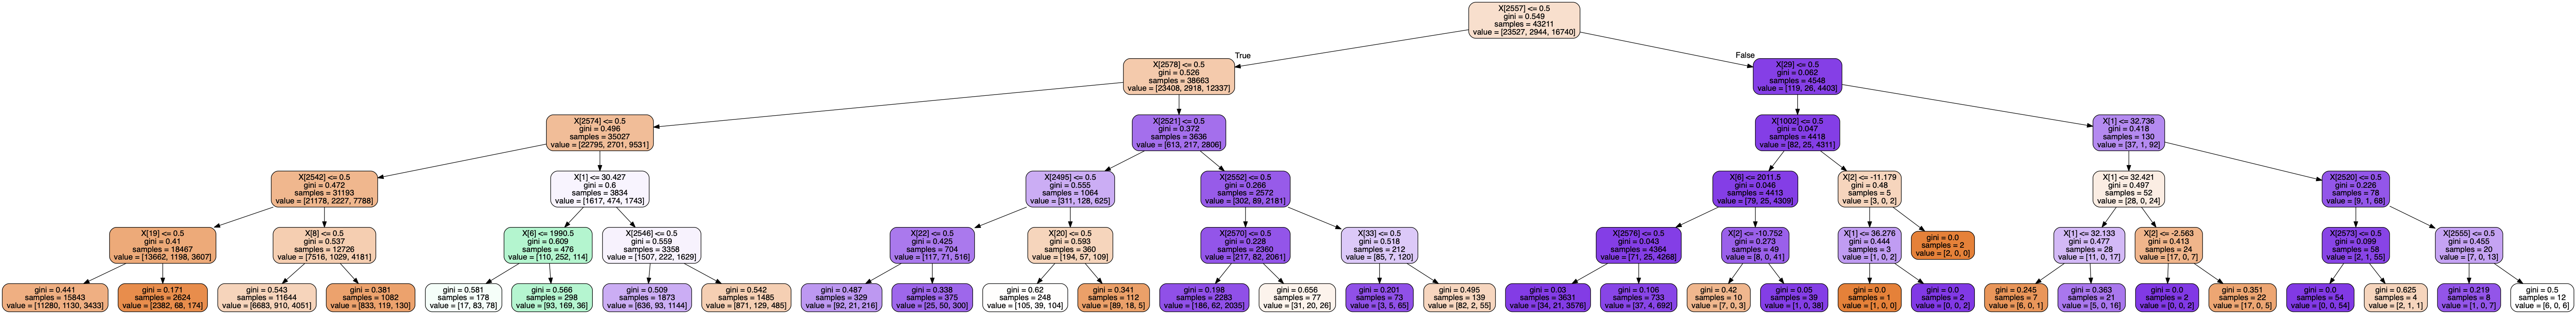

In [62]:
dot_file = StringIO()

export_graphviz(dtc, out_file=dot_file, filled=True,
               rounded=True)

image=pydotplus.graph_from_dot_data(dot_file.getvalue())
Image(image.create_png())

In [80]:
numerical_feature_names[19]

'Iringa'

## Model #2

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 6, 10]
}
rfc = RandomForestClassifier(n_estimators=10, random_state=1, bootstrap=True)
gs = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

In [79]:
gs.fit(joined_train_processed, y_train)

KeyboardInterrupt: 

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

In [ ]:
gs.best_estimator_